### OVERLAND FLOW MODULE

In [10]:
from iotools import read_AsciiGrid
import matplotlib.pyplot as plt
import numpy as np

In [4]:
ffdir = r'/Users/jpnousu/SpaFHy_RUNS/krycklan/gis/25m_3case/flow_direction.asc'
fflowacc = r'/Users/jpnousu/SpaFHy_RUNS/krycklan/gis/25m_3case/flow_accumulation.asc'

In [120]:
def overlandflow(flowacc, fdir, pondsto, airspace):

    # Define movement directions based on fdir
    direction_offsets = {
        64: (-1, 0),   # North
        128: (-1, 1),  # Northeast
        1: (0, 1),     # East
        2: (1, 1),     # Southeast
        4: (1, 0),     # South
        8: (1, -1),    # Southwest
        16: (0, -1),   # West
        32: (-1, -1)   # Northwest
        }
    
    rows, cols = flowacc.shape

    # Create a mask for valid cells (non-nan)
    valid_mask = ~np.isnan(flowacc) & ~np.isnan(fdir) & ~np.isnan(pondsto) & ~np.isnan(airspace)

    # Flatten flowacc for sorting and maintain indices for valid cells only
    flat_indices = np.argsort(flowacc.ravel())  # Sort flowacc values (low to high)
    flat_indices = [i for i in flat_indices if valid_mask.ravel()[i]]  # Filter out invalid indices

    # Iterate through cells in sorted order
    for flat_index in flat_indices:
        r, c = divmod(flat_index, cols)  # Convert flat index to 2D indices
        if pondsto[r, c] > 0:  # Only process cells with water
            # Determine infiltration capacity
            infiltration = min(pondsto[r, c], airspace[r, c])  # Amount of water that can infiltrate
            airspace[r, c] -= infiltration  # Reduce available air space
            pondsto[r, c] -= infiltration  # Reduce water in pondsto by infiltration

            # If there's still water left, flow it to the downstream cell
            if pondsto[r, c] > 0:
                flow_direction = fdir[r, c]
                if flow_direction in direction_offsets:
                    dr, dc = direction_offsets[flow_direction]
                    nr, nc = r + dr, c + dc  # Calculate the neighbor cell

                    # Check if the neighbor cell is within bounds and valid
                    if 0 <= nr < rows and 0 <= nc < cols and valid_mask[nr, nc]:
                        # Move water from current cell to the downstream cell
                        pondsto[nr, nc] += pondsto[r, c]
                        pondsto[r, c] = 0  # Set current cell water to 0 after flow

    return pondsto, airspace

In [135]:
fdir = read_AsciiGrid(ffdir)[0]
flowacc = read_AsciiGrid(fflowacc)[0]

pondsto = np.random.uniform(0, 1, size=flowacc.shape)  # Random values between 0 and 100
pondsto[np.isnan(flowacc)] = np.nan
pondsto_old = pondsto.copy()
airspace = np.random.uniform(0, 10, size=flowacc.shape)  # Random values between 0 and 50
airspace[np.isnan(flowacc)] = np.nan
airspace_old = airspace.copy()

#pondsto = np.ones(shape=fdir.shape)+10
#pondsto[np.isnan(flowacc)] = np.nan
#pondsto_old = pondsto.copy()
##airspace = np.ones(shape=fdir.shape)+20
#airspace_old = airspace.copy()

In [136]:
# Run the model
updated_pondsto, updated_airspace = overlandflow(flowacc, fdir, pondsto, airspace)

# Print result
print("Updated Pond Storage:")
print(updated_pondsto)

Updated Pond Storage:
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


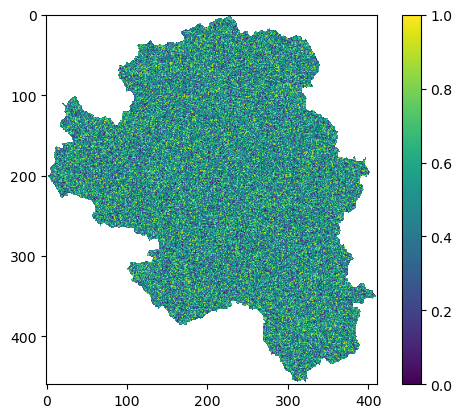

In [137]:
plt.imshow(pondsto_old, vmin=0, vmax=1); plt.colorbar()

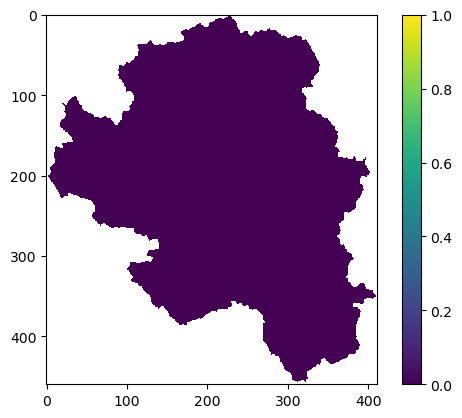

In [138]:
plt.imshow(updated_pondsto, vmin=0, vmax=1); plt.colorbar()

In [133]:
np.nansum(pondsto)

9583.575661262945

In [134]:
np.nansum(updated_pondsto)

9583.575661262945